In [1]:
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.optimize as opt
plt.style.use('fivethirtyeight')
np.random.seed(777)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import pandas_datareader.data as web

import datetime

start = datetime.datetime(2016, 1, 1)

end = datetime.datetime(2017, 12, 31)

## Quandl
Daily financial data (prices of stocks, ETFs etc.) from Quandl. The symbol names consist of two parts: DB name and symbol name. DB names can be all the free ones listed on the Quandl website. Symbol names vary with DB name; for WIKI (US stocks), they are the common ticker symbols, in some other cases (such as FSE) they can be a bit strange. Some sources are also mapped to suitable ISO country codes in the dot suffix style shown above, currently available for BE, CN, DE, FR, IN, JP, NL, PT, UK, US.

ref: 
http://pandas-datareader.readthedocs.io/en/latest/remote_data.html

In [2]:


# f = web.DataReader('AAPL', 'google', start, end)

# A = web.DataReader('AAPL', 'morningstar', start, end)

# f = web.DataReader('AAPL', 'iex', start, end)


symbol = 'WIKI/AAPL'  # or 'AAPL.US'

df = web.DataReader(symbol, 'quandl', '2016-01-01', '2017-12-31')

df.head()

,Open,High,Low,Close,Volume,ExDividend,SplitRatio,AdjOpen,AdjHigh,AdjLow,AdjClose,AdjVolume
Date,,,,,,,,,,,,
2017-12-29,170.52,170.590,169.220,169.23,25643711.0,0.0,1.0,170.52,170.590,169.220,169.23,25643711.0
2017-12-28,171.00,171.850,170.480,171.08,15997739.0,0.0,1.0,171.00,171.850,170.480,171.08,15997739.0
2017-12-27,170.10,170.780,169.710,170.60,21672062.0,0.0,1.0,170.10,170.780,169.710,170.60,21672062.0
2017-12-26,170.80,171.470,169.679,170.57,32968167.0,0.0,1.0,170.80,171.470,169.679,170.57,32968167.0
2017-12-22,174.68,175.424,174.500,175.01,16052615.0,0.0,1.0,174.68,175.424,174.500,175.01,16052615.0


We are focus on the adjusted close price.

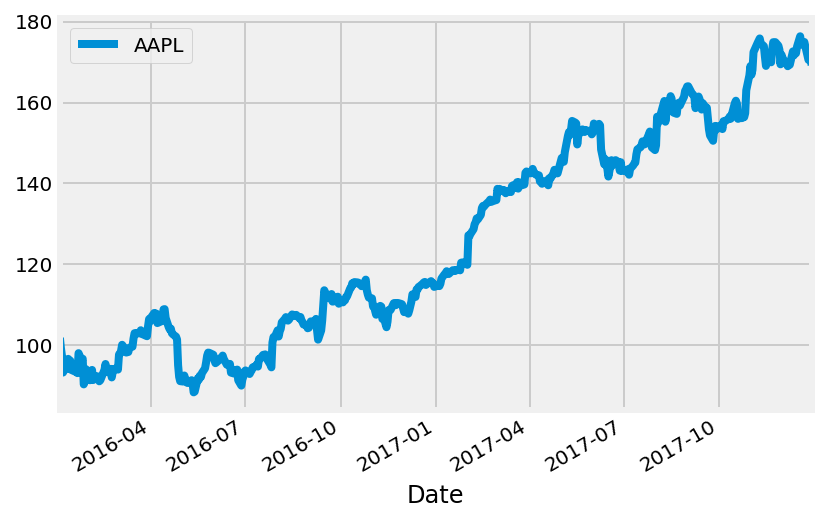

In [3]:
stock = df.loc[:,['AdjClose']]
stock.columns = ['AAPL']
stock.plot()

In [4]:
stock=stock.sort_index()

In [5]:
stock.head()


,AAPL
Date,
2016-01-04,101.783763
2016-01-05,99.233131
2016-01-06,97.291172
2016-01-07,93.185040
2016-01-08,93.677776


In [6]:
def get_stock(tick, start='2016-01-01', end='2017-12-31' ):
    #You have submitted an incorrect Quandl code. Please check your Quandl codes and try again.\n'
    symbol = 'WIKI/' + tick # or tick+'.US'
    df = web.DataReader(symbol, 'quandl', start, end)
    stock = df.loc[:,['AdjClose']]
    stock.columns = [tick]
    stock=stock.sort_index()
    return stock

In [7]:
get_stock('AMZN').head()

,AMZN
Date,
2016-01-04,636.99
2016-01-05,633.79
2016-01-06,632.65
2016-01-07,607.94
2016-01-08,607.05


In [8]:
stock.join(get_stock('AMZN')).head()

,AAPL,AMZN
Date,,
2016-01-04,101.783763,636.99
2016-01-05,99.233131,633.79
2016-01-06,97.291172,632.65
2016-01-07,93.185040,607.94
2016-01-08,93.677776,607.05


In [9]:
#ticks = ['AAPL','AMZN','GOOGL','FB']
ticks = ['AAPL','AMZN','GOOGL','FB','SBUX','NKE','WMT','GE','TSLA']
# for i in ticks[1:]:
#     stock = stock.join(get_stock(i))

Text(0,0.5,'price in $')

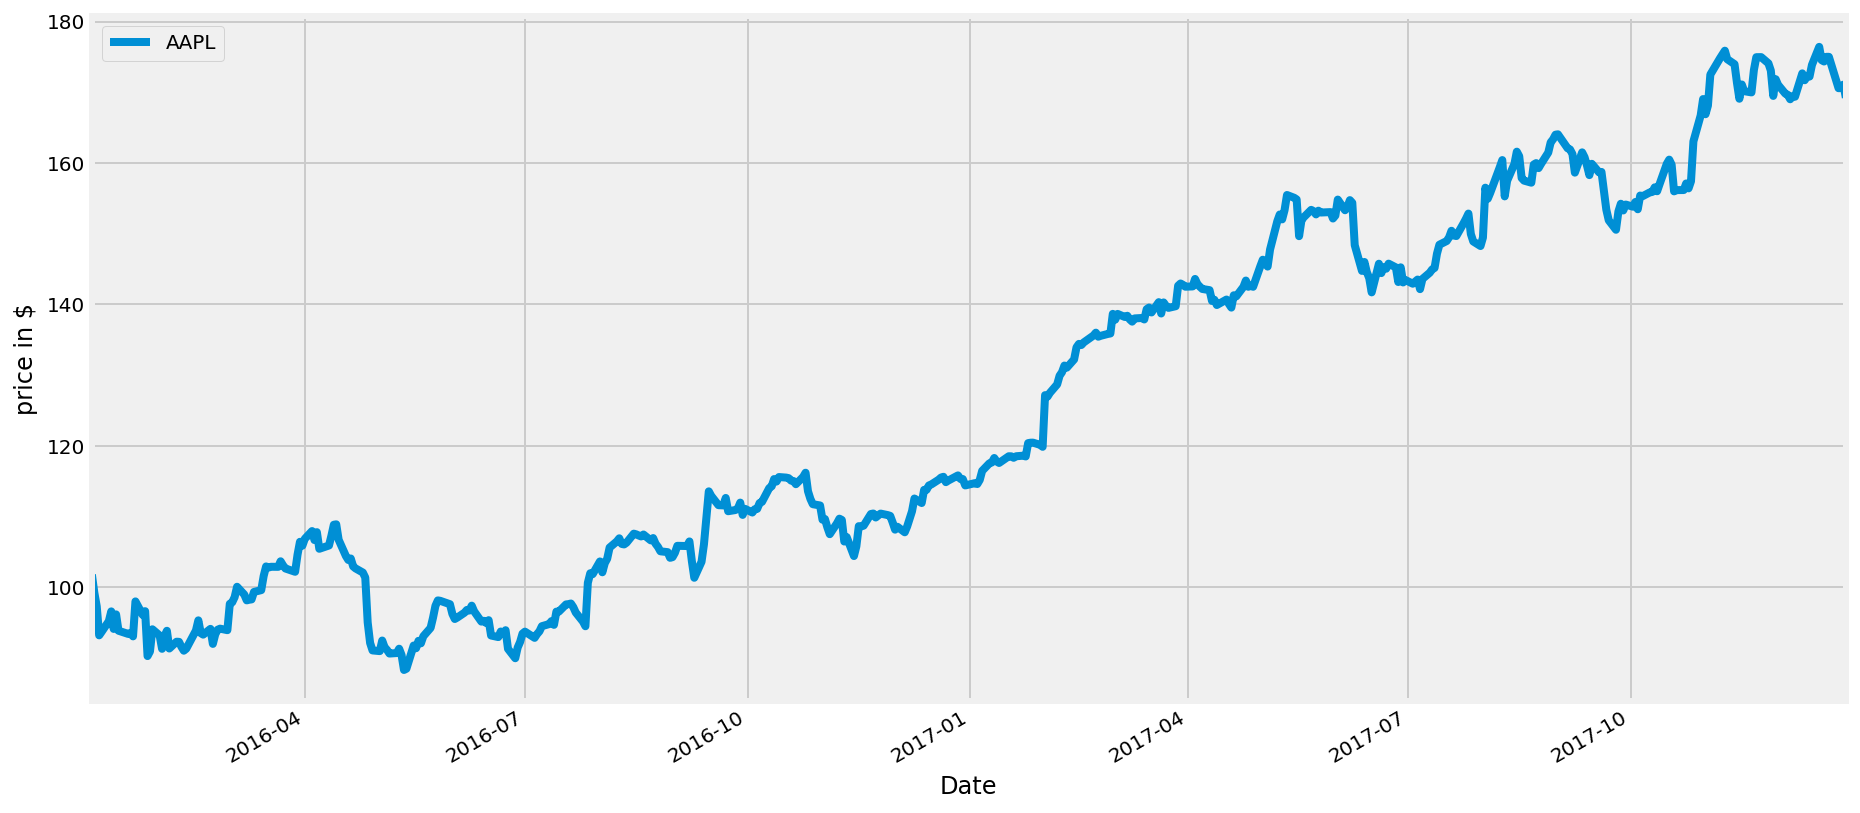

In [10]:

stock.plot(figsize=(14, 7))
plt.ylabel('price in $')

In [11]:
def get_stocks(ticks, start='2016-01-01', end='2017-12-31'):

    stock= get_stock(ticks[0], start, end )
    for i in ticks[1:]:
        stock = stock.join(get_stock(i, start, end ))
    return stock

In [12]:
stocks = get_stocks(ticks)

Text(0,0.5,'price in $')

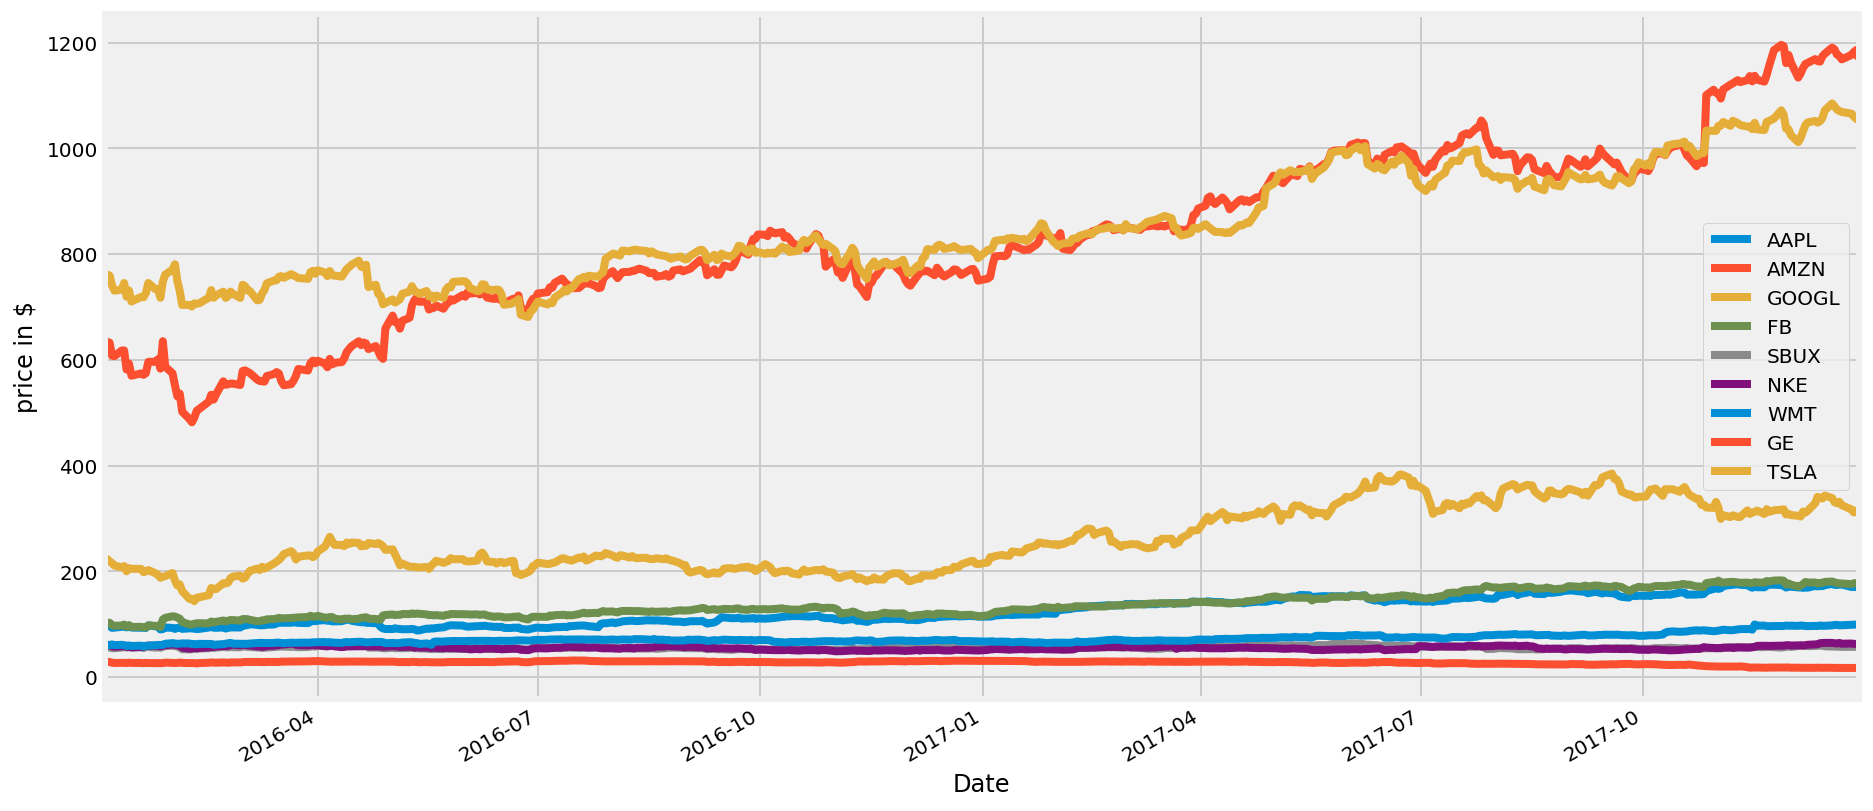

In [13]:
stocks.plot(figsize=(14, 7))
plt.ylabel('price in $')

Text(0,0.5,'daily returns')

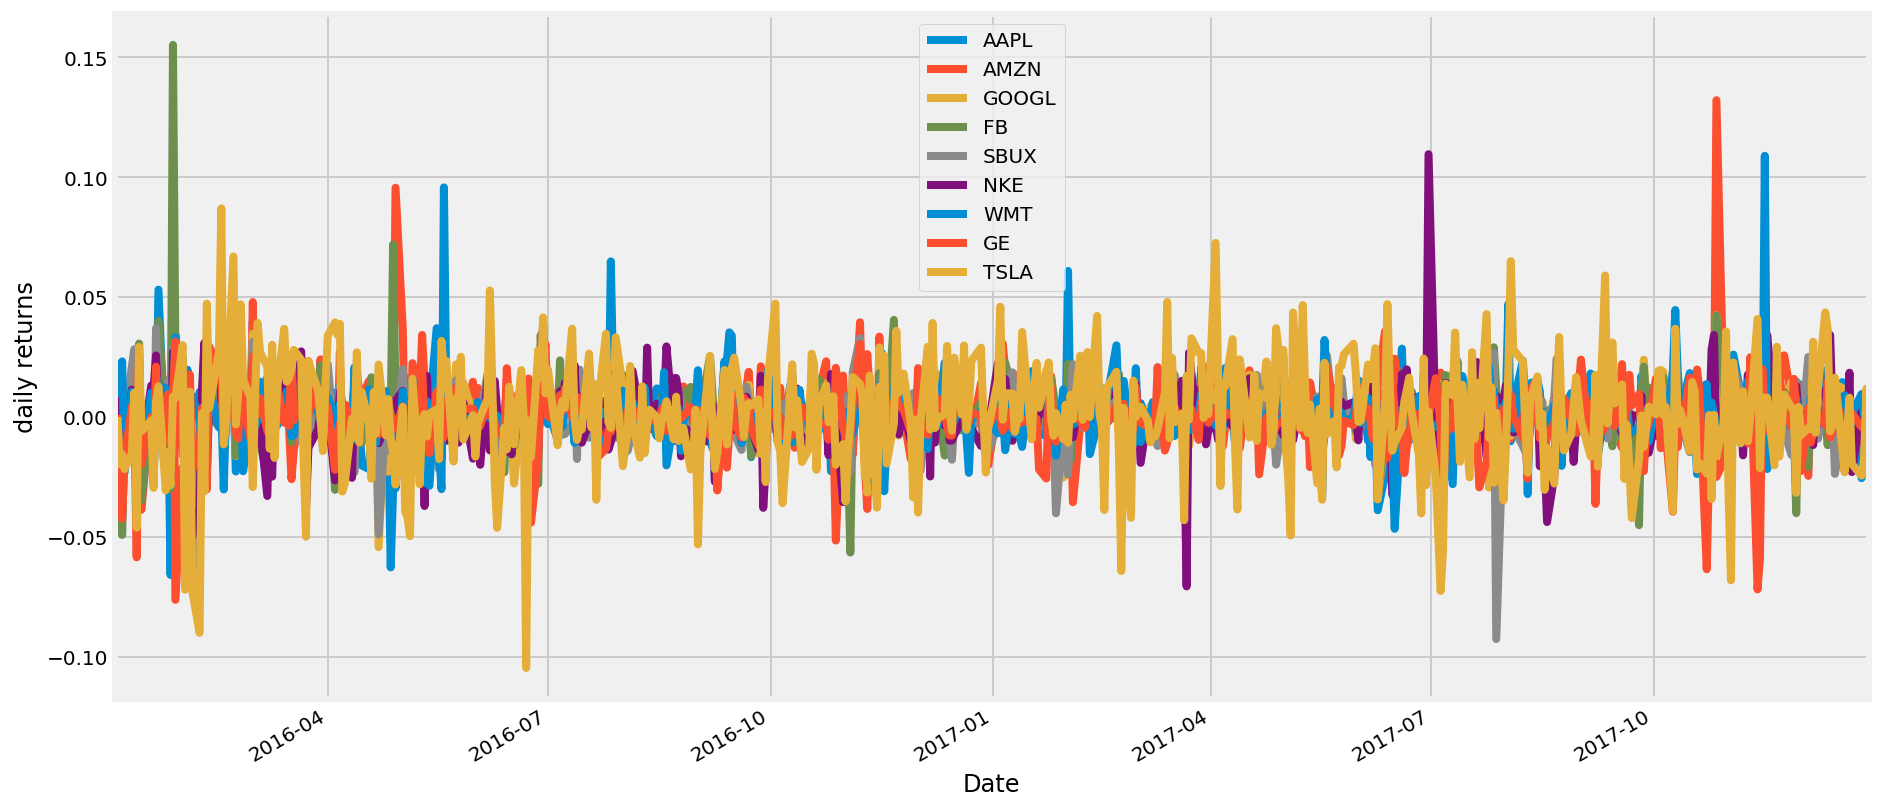

In [14]:

returns = stocks.pct_change()
returns.plot(figsize=(14, 7))
plt.ylabel('daily returns')

In [15]:

mean_returns = returns.mean()

cov_matrix = returns.cov()

In [16]:
def portfolio_annualised_performance(weights, 
                                     returns, 
                                     risk_free_rate =0.02):
    """
    Compute the annualized return 
    and standard diveation
    and sharpe ratio
    """
    mean_returns = returns.mean()
    cov_matrix = returns.cov()
    returns = np.sum(mean_returns*weights ) *252
    std = np.sqrt(weights.T@cov_matrix@weights) * np.sqrt(252)
    sharpe = (returns - risk_free_rate) / std
    return std,returns,  sharpe

## Modern Portfolio Theory (MPT) 

Modern Portfolio Theory (MPT) is an investment theory developed by Harry Markowitz and published under the title “Portfolio Selection” in the Journal of Finance in 1952.

![](https://cdn-images-1.medium.com/max/2000/1*z3qQHXi4CyTtb_oSKInvYA.png)

formula can be expressed in matrix calculation

![](https://cdn-images-1.medium.com/max/1600/1*Fe8_FBagP5p3RHBhzW2Ijg.gif)

## Risk free rate:

1-Year Treasury Bill: Secondary Market Rate (DTB1YR)

ref:

https://fred.stlouisfed.org/series/DTB1YR


In [17]:
Rf = web.DataReader(['DTB1YR'], 'fred', start, '2018-03-07')

In [18]:
Rf.tail()

,DTB1YR
DATE,
2018-02-28,2.01
2018-03-01,1.99
2018-03-02,2.00
2018-03-05,2.00
2018-03-06,2.00


Text(0,0.5,'Risk free rate')

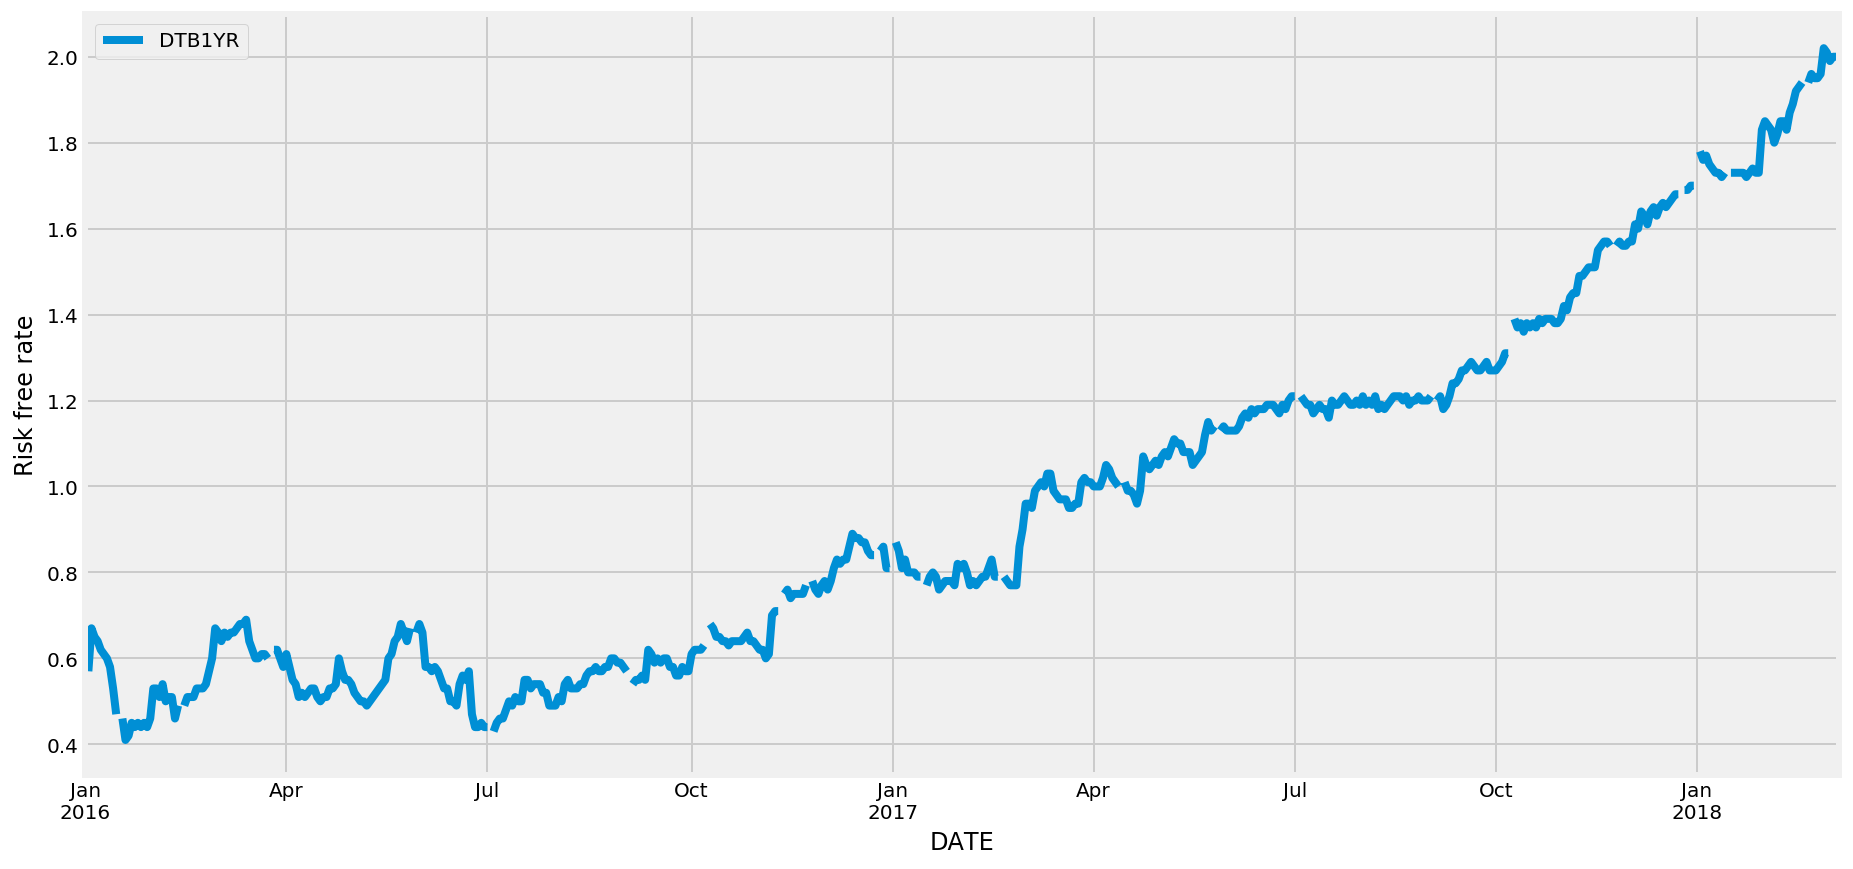

In [19]:
Rf.plot(figsize=(14, 7))
plt.ylabel('Risk free rate')



### Sharpe ratio
The Sharpe ratio was derived in 1966 by William Sharpe, another winner of a Nobel Memorial Prize in Economic Sciences.
![](https://cdn-images-1.medium.com/max/1600/1*aXiygSH2vLBUwAFTZKW47g.jpeg)
Risk-adjusted return refines an investment’s return by measuring how much risk is involved in producing that return, which is generally expressed as a number or rating. 


![](https://cdn-images-1.medium.com/max/1500/1*fo_KcYDFTQ-C9iriE67r2w.png)

In [34]:
def sharpe_ratio(weights, returns, 
                 risk_free_rate):
    
    return portfolio_annualised_performance(weights, 
                                            returns, 
                                            risk_free_rate)[2]

def neg_sharpe_ratio(weights, returns, 
                     risk_free_rate):
    return - sharpe_ratio(weights, returns, 
                          risk_free_rate)
#In Scipy’s optimize function, there’s no ‘maximize’, so as an objective function you need to pass something that should be minimized. That is why the first “neg_sharpe_ratio” is computing the negative Sharpe ratio.

def max_sharpe_ratio(returns,risk_free_rate):
    """
    Solve the max sharpe ratio portifolio"""
    mean_returns = returns.mean()
    cov_matrix = returns.cov()
    num_assets = len(mean_returns)
    args = (returns, risk_free_rate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1}) #np.sum(x) == 1 has become np.sum(x)-1
    bound = (0.0,1.0)
    # Multiply a tuple with a tuple as its item. Don't forget a trailing ,.
    bounds = (bound,)*num_assets  # tuple(bound for asset in range(num_assets))
    x0=[1./num_assets,]*num_assets # Multiply a list with a number as its item. Don't forget a trailing ,.
    solution = opt.minimize(neg_sharpe_ratio, x0=x0, 
                           args=args,  # other arguments for function neg_sharpe_ratio
                           method='SLSQP', 
                           bounds=bounds, 
                           constraints=constraints)
    return solution

We can also define the optimizing function for calculating minimum volatility portfolio. This time we really do minimize the objective function. What do we want to minimize? We want to minimize volatility by trying different weights. "constraints" and "bounds" are same as the above.

In [35]:
def portfolio_volatility(weights, returns):
    return portfolio_annualised_performance(weights, 
                                            returns)[0]

def min_variance(returns):
    mean_returns = returns.mean()
    cov_matrix = returns.cov()    
    num_assets = len(mean_returns)
    args = (returns)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = (bound,)*num_assets
    x0=[1./num_assets,]*num_assets # Multiply a list with a number as its item. Don't forget a trailing ,.

    solution = opt.minimize(portfolio_volatility, 
                          x0=x0, args=args,
                          method='SLSQP', 
                          bounds=bounds, 
                          constraints=constraints)

    return solution



In [24]:
def random_portfolios(num_portfolios,returns, risk_free_rate):
    """
    Monte Carlo ramdon portfolio return, std, and sharpe
    """
    mean_returns = returns.mean()
    cov_matrix = returns.cov()
    results = np.zeros((3,num_portfolios))
    weights_record = np.zeros((len(mean_returns),num_portfolios))
    for i in np.arange(num_portfolios):
        weights = np.random.random(len(mean_returns))
        weights /= np.sum(weights)
        weights_record[:,i] =weights
        portfolio_std_dev, portfolio_return, sharpe = portfolio_annualised_performance(weights, returns,risk_free_rate)
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        results[2,i] = sharpe
    return results, weights_record

In [25]:
num_portfolios = 25000
risk_free_rate = Rf.iloc[-1]['DTB1YR']/100

In [26]:
risk_free_rate

0.02

In [27]:
mean_returns.index

Index(['AAPL', 'AMZN', 'GOOGL', 'FB', 'SBUX', 'NKE', 'WMT', 'GE', 'TSLA'], dtype='object')

In [28]:
def display_simulated_ef_with_random(returns, 
                                     num_portfolios, 
                                     risk_free_rate):
    
    """
    display efficient frontie with random portfolio
    choose the max sharpe and min volatility portfolio from random samples
    """
    mean_returns = returns.mean()
    cov_matrix = returns.cov()
    results, weights = random_portfolios(num_portfolios,returns,risk_free_rate)
    
    # find the max sharpe
    max_sharpe_idx = np.argmax(results[2])
    max_sharpe = np.max(results[2])
    sdp, rp = results[0,max_sharpe_idx], results[1,max_sharpe_idx]
    
    # for pretty printing
    max_sharpe_allocation = pd.DataFrame(weights[:,max_sharpe_idx],
                                         index=mean_returns.index,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    
    # find the min volatility
    min_vol_idx = np.argmin(results[0])
    min_vol = np.min(results[0])
    
    sdp_min, rp_min = results[0,min_vol_idx], results[1,min_vol_idx]
    min_vol_allocation = pd.DataFrame(weights[:,min_vol_idx],index=mean_returns.index,columns=['allocation'])
    
    # for pretty printing
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    print( "-"*80)
    print( "Maximum Sharpe Ratio Portfolio Allocation:{:.2f}\n".format(max_sharpe))
    print( "Annualised Return:", round(rp,2))
    print( "Annualised Volatility:", round(sdp,2))
    print( "\n")
    print( max_sharpe_allocation)
    print( "-"*80)
    print( "Minimum Volatility Portfolio Allocation:{:.2f}\n".format(min_vol))
    print( "Annualised Return:", round(rp_min,2))
    print( "Annualised Volatility:", round(sdp_min,2))
    print( "\n")
    print( min_vol_allocation)
    
    # anualized volatility and return
    an_vol = np.std(returns) * np.sqrt(252)
    an_rt = mean_returns * 252
    
    fig, ax = plt.subplots(figsize=(10, 7))
    ax.scatter(an_vol,an_rt,marker='o',s=200)
    # plot each volatility and return for each asset
    for i, txt in enumerate(mean_returns.index):
        ax.annotate(txt, (an_vol[i],an_rt[i]), xytext=(10,0), textcoords='offset points')
    
    
    # Monte Carlo samples
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    # Maximum Sharp ratio portfolio
    plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    # Minimum Volatility portfolio
    plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')
    plt.title('Simulated Portfolio Optimization Colord by Sharpe Ratio')
    plt.xlabel('annualised volatility')
    plt.ylabel('annualised returns')
    plt.legend(labelspacing=0.8)

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation:1.76

Annualised Return: 0.27
Annualised Volatility: 0.14


            AAPL  AMZN  GOOGL    FB  SBUX   NKE    WMT    GE  TSLA
allocation  23.2  28.7   5.45  3.74  3.09  3.57  27.19  0.51  4.55
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation:0.12

Annualised Return: 0.11
Annualised Volatility: 0.12


             AAPL  AMZN  GOOGL    FB  SBUX   NKE    WMT     GE  TSLA
allocation  15.46  1.75  11.93  5.71  6.76  7.28  25.27  23.82  2.02


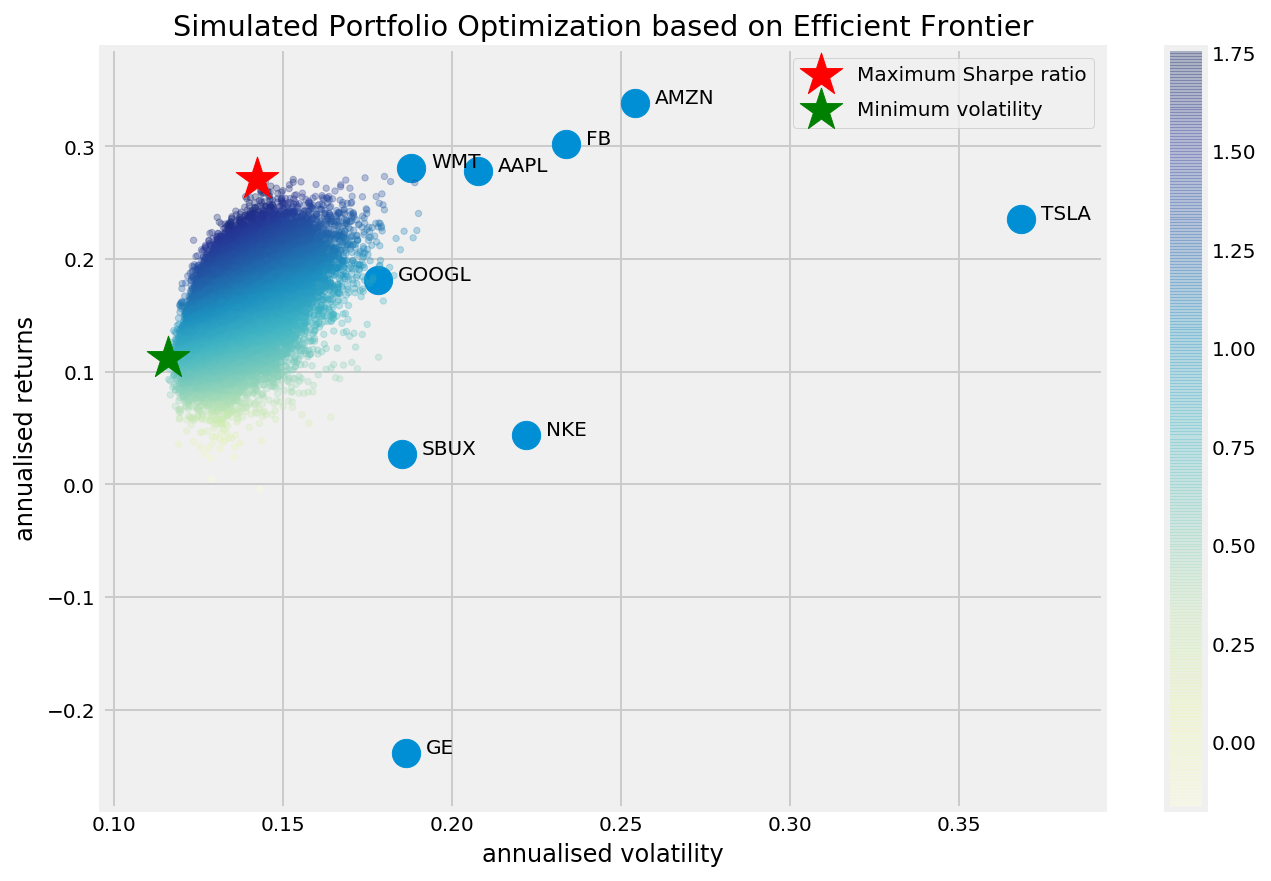

In [30]:
display_simulated_ef_with_random(returns, num_portfolios, risk_free_rate)


In [31]:
def efficient_return(returns, target):
    mean_returns = returns.mean()
    cov_matrix = returns.cov()
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    # for constraint of targe return
    def portfolio_return(weights):
        return portfolio_annualised_performance(weights, 
                                                returns)[1]

    constraints = ({'type': 'eq', 'fun': lambda x: portfolio_return(x) - target},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = ((0,1),)*num_assets
    x0 = num_assets*[1./num_assets,]
    solution = opt.minimize(portfolio_volatility, 
                            x0=x0, 
                            args=args, method='SLSQP', 
                            bounds=bounds, constraints=constraints)
    return solution # include 'fun' objetive funtion value: return, 'x' weights


def efficient_frontier(returns, returns_range):    
    efficientsolutions = [] # list is flexible to store the solutions from Scipy minimization routine
    for ret in returns_range:
        efficientsolutions.append(efficient_return(returns, ret))
    return efficientsolutions

In [40]:
def display_calculated_ef_with_random(returns, 
                                      num_portfolios, 
                                      risk_free_rate):
    """
    display efficient frontie with random portfolio
    choose max sharpe and min volatitlity portfolio 
    by optimization using scipy.optimization.minimization
    """
        
    mean_returns = returns.mean()
    cov_matrix = returns.cov()
    # only need the std and return from random experiments

    results, _ = random_portfolios(num_portfolios,
                                   returns,  
                                   risk_free_rate)
    
    # find the max sharpe by optimization
    max_sharpe_solution = max_sharpe_ratio(returns,  
                                           risk_free_rate)
    
    sdp, rp,max_sharpe = portfolio_annualised_performance(
        max_sharpe_solution['x'], 
        returns,
        risk_free_rate)
    # for pretty printing
    max_sharpe_allocation = pd.DataFrame(max_sharpe_solution['x'],
                                         index=mean_returns.index,
                                         columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    
    # find min volatility by optimization
    min_vol_solution = min_variance(returns)
    sdp_min, rp_min, vol_sharpe = portfolio_annualised_performance(
        min_vol_solution['x'], 
        returns, 
        risk_free_rate)
    min_vol_allocation = pd.DataFrame(min_vol_solution['x'],
                                      index=mean_returns.index,
                                      columns=['allocation'])
    # for pretty printing
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    print( "-"*80)
    print( "Maximum Sharpe Ratio Portfolio Allocation:{:.2f}\n".format(max_sharpe))
    print( "Annualised Return:", round(rp,2))
    print( "Annualised Volatility:", round(sdp,2))
    print( "\n")
    print( max_sharpe_allocation)
    print( "-"*80)
    print( "Minimum Volatility Portfolio Allocation with Sharpe:{:.2f}\n".format(vol_sharpe))
    print( "Annualised Return:", round(rp_min,2))
    print( "Annualised Volatility:", round(sdp_min,2))
    print( "\n")
    print( min_vol_allocation)
    
    # anualized volatility and return for each asset
    an_vol = np.std(returns) * np.sqrt(252)
    an_rt = mean_returns * 252
    
    fig, ax = plt.subplots(figsize=(10, 7))
    
    # plot each volatility and return for each asset
    ax.scatter(an_vol,an_rt,marker='o',s=200)
    
    for i, txt in enumerate(mean_returns.index):
        ax.annotate(txt, (an_vol[i],an_rt[i]), xytext=(10,0), textcoords='offset points')
    
    
    # Monte Carlo samples with color map 'YlGnBu' and color is the value of sharpe ratio
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    # Maximum Sharp ratio portfolio
    plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    # Minimum Volatility portfolio
    plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')
    
    # compute and plot efficient frontie
    target = np.linspace(rp_min, 0.32, 50)
    efficient_portfolios = efficient_frontier(returns, target)
    # a list of solutions of efficient portifolio
    # p['fun] is the objective function value: return
    plt.plot([p['fun'] for p in efficient_portfolios], target, linestyle='-.', 
             color='black', label='efficient frontier')
    plt.title('Calculated Portfolio Optimization based on Efficient Frontier Colord by Sharpe Ratio')
    plt.xlabel('annualised volatility')
    plt.ylabel('annualised returns')
    plt.legend(labelspacing=0.8)

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation:1.97

Annualised Return: 0.29
Annualised Volatility: 0.14


             AAPL   AMZN  GOOGL     FB  SBUX  NKE    WMT   GE  TSLA
allocation  22.08  18.08    0.0  13.23   0.0  0.0  46.61  0.0   0.0
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation with Sharpe:0.69

Annualised Return: 0.1
Annualised Volatility: 0.11


             AAPL  AMZN  GOOGL   FB   SBUX   NKE    WMT     GE  TSLA
allocation  10.99  2.77  16.87  0.0  10.57  9.22  26.87  22.71   0.0


ValueError: Objective function must return a scalar

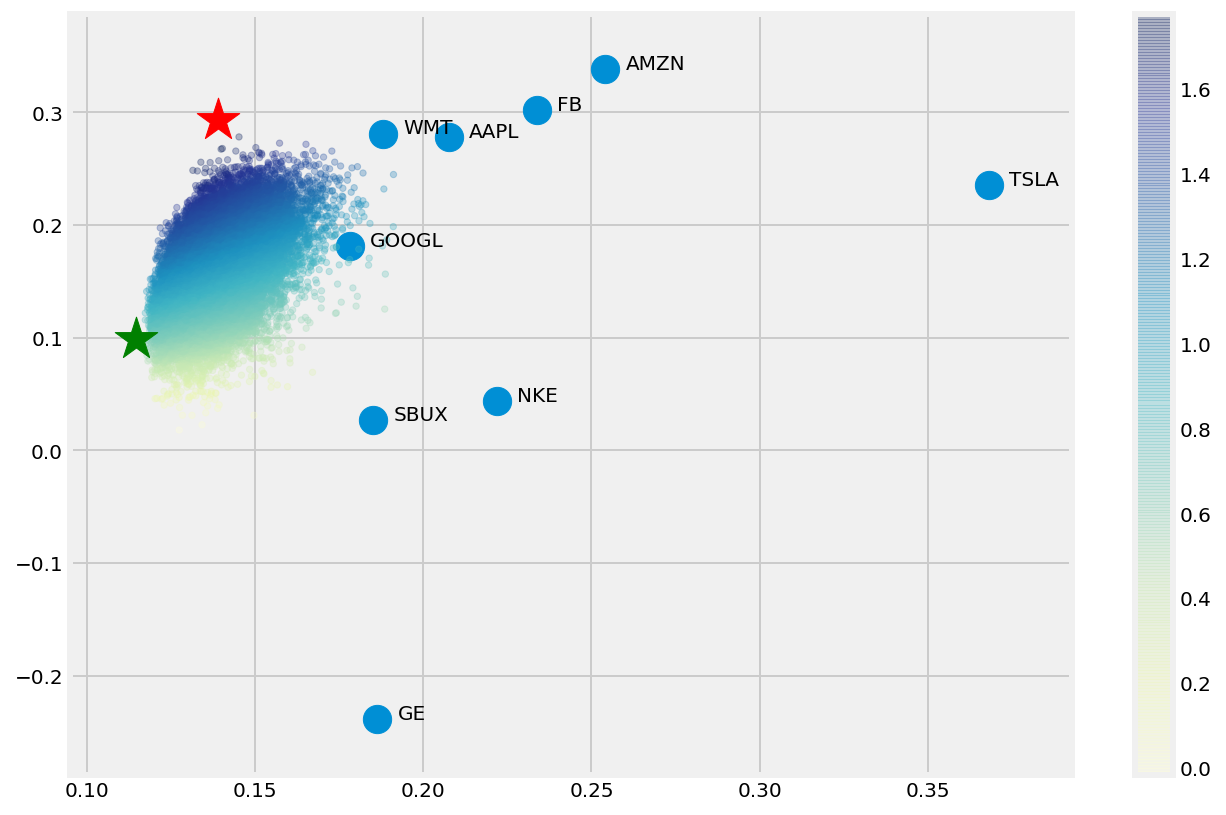

In [41]:
display_calculated_ef_with_random(returns,                                  
                                  num_portfolios, 
                                  risk_free_rate)